## ライブラリimport

In [9]:
#!/usr/bin/python3
#encoding: utf-8
from tqdm import tqdm
# tqdm = lambda x: x

import cv2
import numpy as np
import math
from PIL import Image
from scipy import ndimage
from skimage.feature import hog

from matplotlib import pyplot as plt

%matplotlib inline

In [10]:
red, blue = min, max

In [11]:
# 関係ないメソッド
def fill_img(img, bgr, fat=1):
    img = np.copy(img)
    # target = np.copy(img[10][10])
    target = np.copy(avg_color(img, 0, 2, 0, 2))
    for row in img:
        for i, t in enumerate(row):
            if np.linalg.norm(target - t) < fat:
                row[i] = np.copy(bgr)
    return img

In [12]:
# 関係ないメソッド
def avg_color(img, x1, x2, y1, y2):
    length = (x2 - x1) * (y2 - y1)
    b = np.sum(img[y1:y2, x1:x2, 0]) / length
    g = np.sum(img[y1:y2, x1:x2, 1]) / length
    r = np.sum(img[y1:y2, x1:x2, 2]) / length
    return np.array([b, g, r])

In [13]:
# 輪郭抽出 cvパワー全開
# 大きめの画像を抽出して、赤多めか、青多めかでチーム決定してます
def get_contour(img, team):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gaus = cv2.GaussianBlur(gray, (11, 11), 0)
    th2 = cv2.adaptiveThreshold(gaus, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)
    contours = cv2.findContours(th2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
    contours = [x for x in contours if cv2.contourArea(x) > 60000]
    party = []
    for i, c in enumerate(contours):
        x, y, w, h = cv2.boundingRect(c)
        trim = img[y:y+h, x:x+w]
        party.append([np.sum(trim[:, :, 0] > trim[:, :, 1]), c])
    return team(party, key=lambda x:x[0])[1]

In [14]:
# 切り取られたパーティ画像をいい感じに回転させる処理
def adjast_img(img, team):
    rect = cv2.minAreaRect(get_contour(img, team))
    box = cv2.boxPoints(rect)
    box = sorted(box, key=lambda x: x[1])
    target = [box[0], box[1]] if np.linalg.norm((box[0] - box[1]).astype(np.float64)) < np.linalg.norm((box[1] - box[2]).astype(np.float64)) else [box[1], box[2]]
    k = math.atan2(target[1][0] - target[0][0], target[1][1] - target[0][1])
    result = ndimage.rotate(img, 90 - math.degrees(k))
    return result

In [15]:
# パーティ画像をまっすぐに回転させて切り取り
def trimming(img, team):
    img = adjast_img(img, team)
    x, y, w, h = cv2.boundingRect(get_contour(img, team))
    return img[y:y+h, x:x+w]

In [16]:
# 画像指定img_pathにパーティの画像
i = 2
img_path = "images/sample%d.jpg" %i
img = cv2.imread(img_path)

orgHeight, orgWidth = img.shape[:2]

area = orgHeight * orgWidth

magni = 1000 / orgWidth
img = cv2.resize(img, (int(orgWidth * magni), int(orgHeight * magni)))

In [17]:
# パーティ全体の切り取り
# trimedにパーティ全体が格納されている
trimed = trimming(img, red)

h, w = trimed.shape[:2]
bh = h//7
th = lambda x: bh + (h - bh) // 3 * x
nar = 10
img_size = (100, 100)

In [18]:
# ここからポケモン切り抜き作業
pokemons = []
for t in range(3):
    img1 = cv2.resize(trimed[th(t) + nar:th(t+1) - int(nar * 1.5), nar:w//2 - int(nar * 1.5)], img_size)
    img2 = cv2.resize(trimed[th(t) + nar:th(t+1) - int(nar * 1.5), nar + w//2:w - int(nar * 1.5)], img_size)
    pokemons.append(img1)
    pokemons.append(img2)
# pokemonsに各ポケモンが格納されている

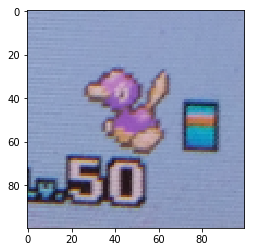

In [26]:
plt.imshow(pokemons[5])

In [ ]:
# 切り抜き終了　以下必要のないコード

min_val = None
result = None

# target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY) // gray scale
pokes = np.load("pokes.npy")
pokes = [cv2.resize(x, img_size) for x in pokes]
for i, img in enumerate(pokemons):
    cv2.imshow("poke%d" %i, img)
### target = pokemons[5]
### 
### flg = False
### 
### try:
###     data = np.load("hog_data.npy")
### except:
###     flg = True
### if flg:
###     data = []
###     print("hog")
###     for p in tqdm(pokes):
###         poke_hogs = []
###         p = fill_img(p, (255, 255, 255))
###         for im in cv2.split(p):
###             im = cv2.GaussianBlur(im, (3,3),0)
###             poke_hogs.extend(hog(im, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(6, 6)))
###         poke_hogs = np.array(poke_hogs)
###         data.append((p, poke_hogs))
###     np.save("hog_data", np.array(data))
###     flg = False
### 
### def sug(target):
###     target_hogs = []
###     for im in cv2.split(target):
###         target_hogs.extend(hog(im, orientations=9, pixels_per_cell=(5, 5), cells_per_block=(6, 6)))
###     target_hogs = np.array(target_hogs)
### 
### 
###     dists = []
###     print("distance")
###     for p, poke_hogs in tqdm(data):
###         dists.append((p, np.sum(np.abs(poke_hogs - target_hogs))))
###     dists.sort(key=lambda x:x[1])
###     # index = np.argmin(np.array(dists))
###     return dists
### num = 5
### fig, axs = plt.subplots(ncols=num + 1, nrows=len(pokemons), figsize=(50, 12))
### for j, t in enumerate(pokemons):
###     print(target[0].shape)
###     t = cv2.GaussianBlur(t, (3,3),0)
###     t = fill_img(t, (255, 255, 255), 40)
###     dists = sug(t)
###     for i, pd in enumerate(dists[:num]):
###         p, d = pd
###         axs[j][i].set_title("sug" + str(i) +": " + str(d)[:5])
###         axs[j][i].imshow(Image.fromarray(p[:, :, ::-1].copy()))
###     axs[j][-1].set_title("origin")
###     axs[j][-1].imshow(Image.fromarray(t[:, :, ::-1].copy()))
### plt.show()
### __import__("sys").exit()



# target = cv2.GaussianBlur(target, (11, 11), 1)
# target = fill_img(target, (0, 0, 0), 30)
# print(target.shape)
# target = pokes[int(__import__("sys").argv[2])]
###hists = []
###hists_b = []
###hists_r = []
###hists_g = []
###hists_gray = []
###hists_all = []
###
###np.save("origin", np.array(pokemons))
###
#### for i, p in enumerate(pokes):
###target_hist = cv2.calcHist([target], [1], None, [256], [0, 256])
###target_hist_r = cv2.calcHist([target], [0], None, [256], [0, 256])
###target_hist_g = cv2.calcHist([target], [1], None, [256], [0, 256])
###target_hist_b = cv2.calcHist([target], [2], None, [256], [0, 256])
###t_target_hist_r = cv2.calcHist([target], [0], None, [256], [0, 256])
###t_target_hist_g = cv2.calcHist([target], [1], None, [256], [0, 256])
###t_target_hist_b = cv2.calcHist([target], [2], None, [256], [0, 256])
###target_gray = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)
###target_hist_gray = cv2.calcHist([target_gray], [0], None, [256], [0, 256])
###for i, p in tqdm(list(enumerate(pokes))):
###
###    # target_bgr = avg_color(p, 0, 20, 0, 20)
###    # filled = fill_img(p, target_bgr, 5)
###    # pokemon_hist = cv2.calcHist([filled], [0], None, [256], [0, 256])
###    # target_g = cv2.cvtColor(p, cv2.COLOR_RGB2GRAY)
###    # target_g = cv2.GaussianBlur(target_g, (11, 11), 1)
###    # laped = cv2.Laplacian(target_g, cv2.CV_32F)
###    # _, im01 = cv2.threshold(laped, 10, 1, cv2.THRESH_BINARY)
###    # p = cv2.convertScaleAbs(im01)
###
###    pokemon_hist = cv2.calcHist([p], [1], None, [256], [0, 256])
###    pokemon_hist_r = cv2.calcHist([p], [0], None, [256], [0, 256])
###    pokemon_hist_g = cv2.calcHist([p], [1], None, [256], [0, 256])
###    pokemon_hist_b = cv2.calcHist([p], [2], None, [256], [0, 256])
###    p_gray = cv2.cvtColor(p, cv2.COLOR_RGB2GRAY)
###    pokemon_hist_gray = cv2.calcHist([p], [0], None, [256], [0, 256])
###
###    # pokemon_hist = cv2.calcHist([cv2.cvtColor(p, cv2.COLOR_RGB2GRAY)], [0], None, [256], [0, 256])
###
###    compared = cv2.compareHist(target_hist, pokemon_hist, 0)
###    compared_r = cv2.compareHist(target_hist_r, pokemon_hist_r, 0)
###    compared_g = cv2.compareHist(target_hist_g, pokemon_hist_g, 0)
###    compared_b = cv2.compareHist(target_hist_b, pokemon_hist_b, 0)
###    compared_gray = cv2.compareHist(target_hist_gray, pokemon_hist_gray, 0)
###
###    compared = cv2.compareHist(target_hist, pokemon_hist, 0)
###    hists.append([abs(compared), p, pokemon_hist])
###    hists_r.append([abs(compared_r), p, pokemon_hist_r])
###    hists_g.append([abs(compared_g), p, pokemon_hist_g])
###    hists_b.append([abs(compared_b), p, pokemon_hist_b])
###    hists_gray.append([abs(compared_gray), p, pokemon_hist_gray])
###    hists_all.append([abs(compared_r) + abs(compared_g) + abs(compared_b), p, None])
    # if min_val == None or min_val > abs(compared):
    #     result = p
    #     min_val = abs(compared)

# kairyu = np.load("mimi.npy")

# Image.fromarray(target[:, :, ::-1].copy()).show()
# for i, v in enumerate(pokemons):
#     # target_bgr = avg_color(v, 0, 20, 0, 20)
#     # filled = fill_img(kairyu, target_bgr, 5)
#     # target_hist = cv2.calcHist([filled], [0], None, [256], [0, 256])
#
#     # compare_hist = cv2.calcHist([v], [0], None, [256], [0, 256])
#     # compared = cv2.compareHist(target_hist, compare_hist, 0)
#     # print(i, compared)
#     # if min_val == None or min_val > abs(compared):
#     #     result = v
#     #     min_val = abs(compared)
#     # cv2.imshow("%d" %i, v)
#     Image.fromarray(v[:, :, ::-1].copy()).show()
#     # cv2.imshow("m%d" %i, filled)
# hists.sort(key=lambda x: x[0], reverse=True)
# import pylab as plt
###
###def imcompare(im1, im2):
###    try:
###        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
###        detector = cv2.ORB_create()
###        kp1, des1 = detector.detectAndCompute(im1, None)
###        kp2, des2 = detector.detectAndCompute(im2, None)
###        dists = [x.distance for x in bf.match(des1, des2)]
###        return sum(dists) / len(dists)
###    except:
###        return 10000
###    # out = cv2.drawKeypoints(im01, keypoints, None, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
###
###target_g = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)
###target_g = cv2.GaussianBlur(target_g, (11, 11), 1)
###laped = cv2.Laplacian(target_g, cv2.CV_32F)
###_, im01 = cv2.threshold(laped, 10, 1, cv2.THRESH_BINARY)
###im01 = cv2.convertScaleAbs(im01)
# plt.imshow(im01, cmap="gray")
# plt.show()

# compares = [(imcompare(target, p), p) for p in pokes]
# result = sorted(compares, key=lambda x: x[0])


# # # im01 = (laped > 5).astype(np.int)
# #
# target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)
# contours = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
# cv2.drawContours(target, contours, -1, (0, 0, 0), 1)
# print(len(contours))
# print(im01)
# import os
# for i, r in enumerate(result):
#     Image.fromarray(r[1][:, :, ::-1].copy()).show()
#     input()
#     os.system("./killer.sh")

### num = 10
### fig, axs = plt.subplots(ncols=num + 1, nrows=2, figsize=(50, 4))
### # target_hist = cv2.calcHist([im01], [1], None, [256], [0, 256])
### import sys
### mode = sys.argv[1] if len(sys.argv) > 1 else "r"
### hists_field = {"r": 0, "g": 1, "b": 2, "a": 3}
### rgb_hists = zip(hists_r, hists_g, hists_b, hists_all)
### for i, h in enumerate(sorted(rgb_hists, key=lambda x: x[hists_field[mode]][0], reverse=True)[:num]):
###     value, image, hist = h[hists_field[mode]]
###     rv, ri, rh = h[0]
###     gv, gi, gh = h[1]
###     bv, bi, bh = h[2]
###     # grayv, grayi, grayh = hists_gray[i]
###     color = ('b', 'g', 'r')
###     # Image.fromarray(image[:, :, ::-1].copy()).show()
###     # for i,col in enumerate(color):
###     #     histr = cv2.calcHist([img],[i],None,[256],[0,256])
###     axs[0][i].set_xlim([0, 256])
###     axs[0][i].set_ylim([0, 1000])
###     axs[0][i].set_title("sug" + str(i) + " : " + str(value)[:5])
###     if mode in ("b", "a") : axs[0][i].plot(bh, color='b')
###     if mode in ("g", "a") : axs[0][i].plot(gh, color='g')
###     if mode in ("r", "a") : axs[0][i].plot(rh, color='r')
###
###     axs[1][i].imshow(Image.fromarray(image[:, :, ::-1].copy()))
###
### axs[0][-1].set_xlim([0, 256])
### axs[0][-1].set_ylim([0, 1000])
### axs[0][-1].set_title("origin")
### if mode in ("b", "a") : axs[0][-1].plot(t_target_hist_b, color='b')
### if mode in ("g", "a") : axs[0][-1].plot(t_target_hist_g, color='g')
### if mode in ("r", "a") : axs[0][-1].plot(t_target_hist_r, color='r')
### axs[1][-1].imshow(Image.fromarray(target[:, :, ::-1].copy()))
### plt.show()
    # print(h[0])
    # plt.plot(h[0])
    # cv2.imshow("h%d" %i, h[1])
# cv2.imshow("1r", target)
# cv2.imshow("2r", result)

# plt.show()
cv2.waitKey()
# import os
# os.system("./killer.sh")